In [0]:
import glob
import pandas as pd
from google.colab import files
from google.colab import drive
import numpy as np
from tqdm import tqdm
from collections import Counter
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
style = plt.style.use('seaborn-deep')

In [0]:
drive.mount('/content/drive')
!ls "/content/drive/My Drive/Knab/Data/CleanData"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
clean_article_data.csv	      data_recommendations.csv
clean_article_data.gsheet     lookup_urls.csv
clean_event_data.csv	      MissingMatrix500.csv
clean_page_data.csv	      Popularity_score.csv
clean_page_only_articles.csv  ReadMatrix500.csv
ClickedMatrix500.csv	      WeightReadMatrix500.csv


#Load in data

In [0]:
#Page data
df_page = pd.read_csv("/content/drive/My Drive/Knab/Data/CleanData/clean_page_data.csv")

In [0]:
#Load in all urls with tags
df_urlstext = pd.read_csv("/content/drive/My Drive/Knab/Data/CleanData/clean_article_data.csv")

In [0]:
#Split dfs, remove the text for memory space
df_urls = df_urlstext[['URL','TAG','TITLE','DATE','READING_TIME']]

In [5]:
#Change the datetimes (They reset when loading in csv)
df_urls['DATE'] = pd.to_datetime(df_urls['DATE'])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [0]:
#Sort chronologically
df_page = df_page.sort_values(by=['visitstarttime'])

#Calculate the popularity of articles

In [0]:
#Put 0/1 encoding of page is also an article
df_page = df_page.assign(ArticleYN=df_page.URL.isin(df_urls.URL).astype(int))

In [8]:
#Remove big chunk if not usefull data
df_only_articles = df_page.loc[df_page['ArticleYN'] == 1]
df_only_articles['visitstarttime'] = pd.to_datetime(df_only_articles['visitstarttime'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [0]:
#Only article csv
df_only_articles.to_csv('clean_page_only_articles.csv', index=False)

In [0]:
#Only for truncated period
def popularity_period(months,dataframe, column_name_data):
  delta_months = dt.timedelta(days = 30*months)
  date_truncate = dt.datetime(2019, 1, 1, 00, 00) - delta_months   #dt.datetime(2019, 1, 1, 00, 00) should be replaced by dt.datetime.now()
  dataframe = dataframe[dataframe[column_name_data] >= date_truncate]
  
  return dataframe

In [0]:
#### HYPERPARAMETER MONTHS!!! ####
#Truncate the data on number of months
df_truncated = popularity_period(months = 3, dataframe = df_only_articles, column_name_data = 'visitstarttime')

In [0]:
merged_truncated = pd.merge(df_truncated, df_urls[['URL', 'TITLE']], left_on = 'URL', right_on='URL', how='left')
df_merged_truncated = merged_truncated.dropna()
df_popcount = pd.DataFrame(df_merged_truncated.groupby(['TITLE','URL']).size()).reset_index()
df_popcount.columns = ['TITLE', 'URL', 'COUNT']

In [0]:
#Sigmoid function
def log_function (A,K,B,v,Q,C,M,x):
  Y = A + (K-A)/((C+np.exp(-B*(x-M)))**(1/v))
  return Y

In [0]:
#Calculate midpoint with percentile on the right hand side

def find_midpoint(midpoint_percentile, dataframe, columnname):
  df = dataframe.sort_values([columnname], ascending = True) #Lowest on top
  length = len(df)
  index = round(length*(1-midpoint_percentile)) #Calculate index on which the percentile is crossed
  midpoint = df.iloc[index][columnname] #Find the view value on this index
  
  return midpoint

In [0]:
midpoint = find_midpoint(0.01,df_popcount,'COUNT') #Position of max learning rate
max_weight = 1 #Weight will be 1+max_weight
growth_rate = 30/max(df_popcount['COUNT'].values) #Defines steepness in function of the reading value

In [0]:
#Plot different scenarios
percentile = [0.25,0.1,0.05,0.01,0.005]
growth_rate_top = [10,25,50,75,100]
max_weight_list = [0.1,0.2,0.5,0.8,1]
growth_rate_list = growth_rate_top/max(df_popcount['COUNT'].values)

x = np.arange(0,max(df_popcount['COUNT'].values),0.025)

#Different midpoint percentiles with as growth rate 25/max(count)
y_per_1 = log_function(A=0.0,K=max_weight,B=growth_rate_list[1],v=1,Q=1,C=1,M=find_midpoint(percentile[0],df_popcount,'COUNT'), x = x)
y_per_2 = log_function(A=0.0,K=max_weight,B=growth_rate_list[1],v=1,Q=1,C=1,M=find_midpoint(percentile[1],df_popcount,'COUNT'), x = x)
y_per_3 = log_function(A=0.0,K=max_weight,B=growth_rate_list[1],v=1,Q=1,C=1,M=find_midpoint(percentile[2],df_popcount,'COUNT'), x = x)
y_per_4 = log_function(A=0.0,K=max_weight,B=growth_rate_list[1],v=1,Q=1,C=1,M=find_midpoint(percentile[3],df_popcount,'COUNT'), x = x)
y_per_5 = log_function(A=0.0,K=max_weight,B=growth_rate_list[1],v=1,Q=1,C=1,M=find_midpoint(percentile[4],df_popcount,'COUNT'), x = x)

#Different growth rates with as percentile 0.01
y_gr_1 = log_function(A=0.0,K=max_weight,B=growth_rate_list[0],v=1,Q=1,C=1,M=find_midpoint(percentile[3],df_popcount,'COUNT'), x = x)
y_gr_2 = log_function(A=0.0,K=max_weight,B=growth_rate_list[1],v=1,Q=1,C=1,M=find_midpoint(percentile[3],df_popcount,'COUNT'), x = x)
y_gr_3 = log_function(A=0.0,K=max_weight,B=growth_rate_list[2],v=1,Q=1,C=1,M=find_midpoint(percentile[3],df_popcount,'COUNT'), x = x)
y_gr_4 = log_function(A=0.0,K=max_weight,B=growth_rate_list[3],v=1,Q=1,C=1,M=find_midpoint(percentile[3],df_popcount,'COUNT'), x = x)
y_gr_5 = log_function(A=0.0,K=max_weight,B=growth_rate_list[4],v=1,Q=1,C=1,M=find_midpoint(percentile[3],df_popcount,'COUNT'), x = x)

#Different upper asymptotes with as percentile 0.01
y_up_1 = log_function(A=0.0,K=max_weight_list[0],B=growth_rate_list[1],v=1,Q=1,C=1,M=find_midpoint(percentile[3],df_popcount,'COUNT'), x = x)
y_up_2 = log_function(A=0.0,K=max_weight_list[1],B=growth_rate_list[1],v=1,Q=1,C=1,M=find_midpoint(percentile[3],df_popcount,'COUNT'), x = x)
y_up_3 = log_function(A=0.0,K=max_weight_list[2],B=growth_rate_list[1],v=1,Q=1,C=1,M=find_midpoint(percentile[3],df_popcount,'COUNT'), x = x)
y_up_4 = log_function(A=0.0,K=max_weight_list[3],B=growth_rate_list[1],v=1,Q=1,C=1,M=find_midpoint(percentile[3],df_popcount,'COUNT'), x = x)
y_up_5 = log_function(A=0.0,K=max_weight_list[4],B=growth_rate_list[1],v=1,Q=1,C=1,M=find_midpoint(percentile[3],df_popcount,'COUNT'), x = x)

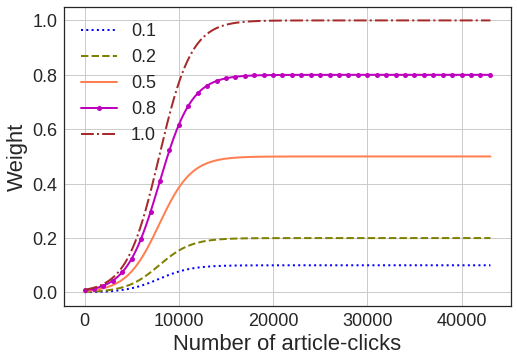

In [21]:
sns.set_style("white")

plt.plot( x , y_up_1, linestyle = ':', color='blue', linewidth=2, ms = 10, markevery = 40000)
plt.plot( x , y_up_2, linestyle = '--', color='olive', linewidth=2, ms = 10, markevery = 40000)
plt.plot( x , y_up_3, color='coral', linewidth=2, ms = 10, markevery = 40000)
plt.plot( x , y_up_4, marker = '.', color='m', linewidth=2, ms = 10, markevery = 40000)
plt.plot( x , y_up_5, linestyle = '-.', color='brown', linewidth=2, ms = 10, markevery = 40000)
plt.legend(['0.1', '0.2', '0.5', '0.8', '1.0'], loc='upper left', prop={'size': 18})
plt.grid()
plt.xlabel('Number of article-clicks', fontsize = 22)
plt.ylabel('Weight', fontsize = 22)
plt.tick_params(labelsize = 18)
plt.show()

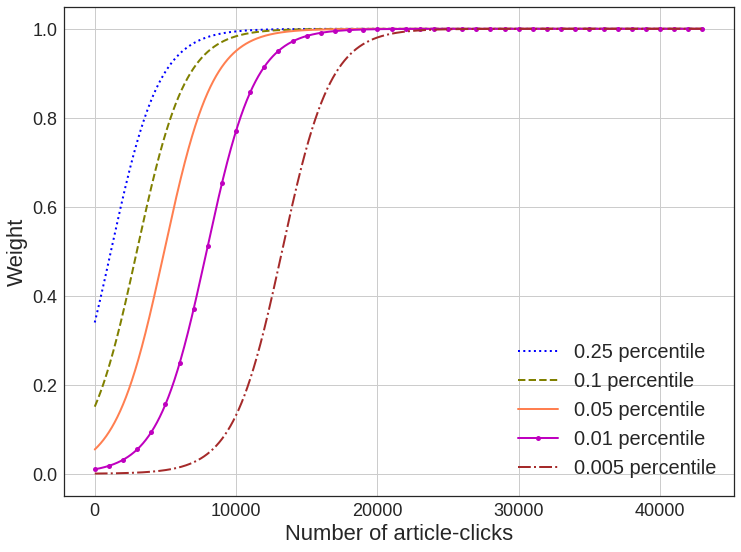

In [27]:
sns.set_style("white")

fig_size = plt.rcParams['figure.figsize']
fig_size[0] = 12
fig_size[1] = 9

plt.plot( x , y_per_1, linestyle = ':', color='blue', linewidth=2, ms = 10, markevery = 40000)
plt.plot( x , y_per_2, linestyle = '--', color='olive', linewidth=2, ms = 10, markevery = 40000)
plt.plot( x , y_per_3, color='coral', linewidth=2, ms = 10, markevery = 40000)
plt.plot( x , y_per_4, marker = '.', color='m', linewidth=2, ms = 10, markevery = 40000)
plt.plot( x , y_per_5, linestyle = '-.', color='brown', linewidth=2, ms = 10, markevery = 40000)
plt.legend(['0.25 percentile', '0.1 percentile', '0.05 percentile', '0.01 percentile', '0.005 percentile'], loc='lower right', prop={'size': 20})
plt.xlabel('Number of article-clicks', fontsize = 22)
plt.ylabel('Weight', fontsize = 22)
plt.grid()
plt.tick_params(labelsize = 18)
plt.show()

In [0]:
growth_rate_top

[10, 20, 30, 40, 50]

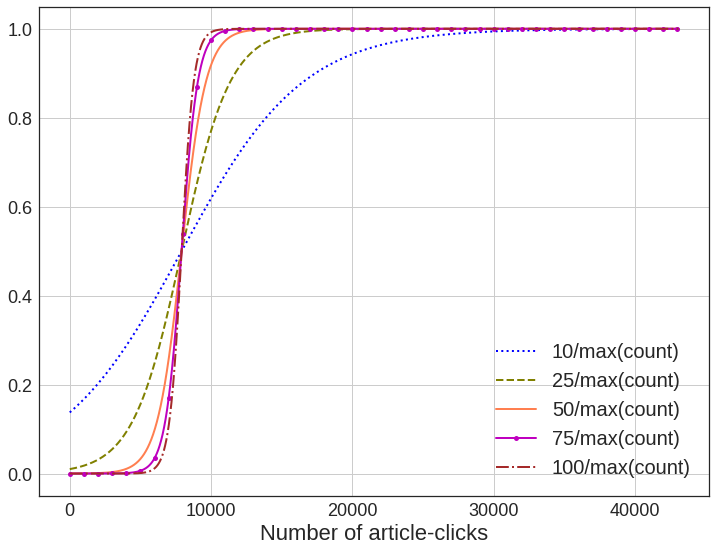

In [26]:
sns.set_style("white")

fig_size = plt.rcParams['figure.figsize']
fig_size[0] = 12
fig_size[1] = 9

plt.plot( x , y_gr_1, linestyle = ':', color='blue', linewidth=2, ms = 10, markevery = 40000)
plt.plot( x , y_gr_2, linestyle = '--', color='olive', linewidth=2, ms = 10, markevery = 40000)
plt.plot( x , y_gr_3, color='coral', linewidth=2, ms = 10, markevery = 40000)
plt.plot( x , y_gr_4, marker = '.', color='m', linewidth=2, ms = 10, markevery = 40000)
plt.plot( x , y_gr_5, linestyle = '-.', color='brown', linewidth=2, ms = 10, markevery = 40000)
plt.legend(['10/max(count)', '25/max(count)', '50/max(count)', '75/max(count)', '100/max(count)'], loc='lower right', prop={'size': 20})
plt.xlabel('Number of article-clicks', fontsize = 22)
plt.grid()
plt.tick_params(labelsize = 18)
plt.show()

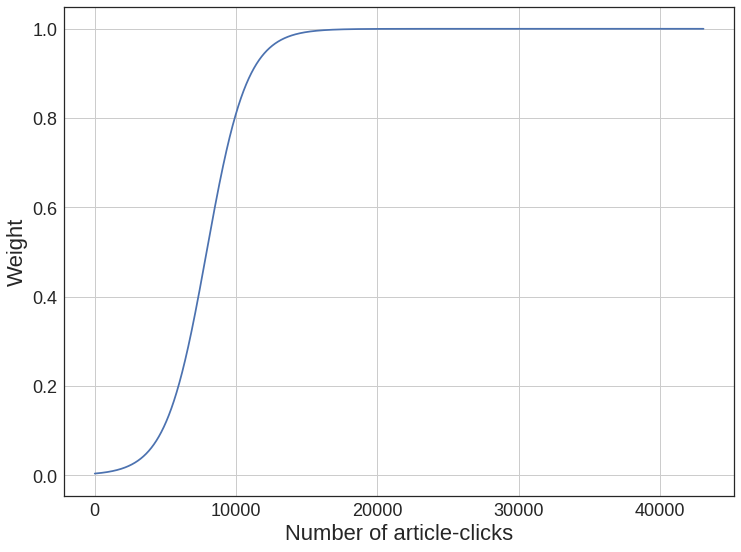

In [28]:
#Make visualization of the function
sns.set_style("white")

fig_size = plt.rcParams['figure.figsize']
fig_size[0] = 12
fig_size[1] = 9

x = np.arange(0,max(df_popcount['COUNT'].values),0.025)
y = log_function(A=0.0,K=1,B=growth_rate,v=1,Q=1,C=1,M=midpoint, x = x)
plt.xlabel('Number of article-clicks', fontsize = 22)
plt.ylabel('Weight', fontsize = 22)
plt.grid()
plt.tick_params(labelsize = 18)
plt.plot(x, y)

In [0]:
#Run the weighing function over the page data
df_popcount['popularity_weight'] = log_function(A=0.0,K=1,B=growth_rate,v=1,Q=1,C=1,M=midpoint, x = df_popcount['COUNT'].values) 

In [0]:
#Visual Check
df_popcount.sort_values(['COUNT'],ascending=False)

,TITLE,URL,COUNT,popularity_weight
72,Belastingvrij sparen in 2018: wat is er verand...,bieb.knab.nl/sparen-investeren/belastingvrij-s...,43070,1.000000
544,Overwaarde huis opnemen en gebruiken: wat zijn...,bieb.knab.nl/hypotheken/overwaarde-huis-opneme...,14839,0.992042
715,Werkgeversverklaring en intentieverklaring: wa...,bieb.knab.nl/hypotheken/werkgeversverklaring-e...,14404,0.989256
112,Bieden op een huis: voorbeeldbrief,bieb.knab.nl/hypotheken/bieden-op-een-huis-voo...,13249,0.976296
749,Zorgverzekering voor zzp'ers en ondernemers: 3...,bieb.knab.nl/ondernemen/zorgverzekering-voor-z...,10999,0.895754
661,Vermogensbelasting: hoeveel kan ik sparen voor...,bieb.knab.nl/sparen-investeren/vermogensbelast...,9845,0.793657
415,Intrekken koophuis: samenwonen in je partners ...,bieb.knab.nl/hypotheken/intrekken-koophuis-sam...,9741,0.781541
279,Huis kopen eigen geld inbrengen: wat betekent ...,bieb.knab.nl/hypotheken/huis-kopen-eigen-geld-...,7911,0.500000
294,Huis kopen om te verhuren: de hypotheek en meer,bieb.knab.nl/hypotheken/huis-kopen-om-te-verhu...,7910,0.499826
86,Betalen uit een bouwdepot: wat wel en wat niet?,bieb.knab.nl/hypotheken//betalen-uit-een-bouwd...,7811,0.482594


In [0]:
#Save to csv
df_popcount.to_csv('/content/drive/My Drive/Knab/Data/CleanData/Popularity_score.csv', index=False)